## Import Libraries

In [24]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

from torch.autograd import Variable
from torchsummary import summary

## Dataset Processing and Visualization

### Download data from Kaggle

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection

Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 99%|███████████████████████████████████████▊| 429M/431M [00:15<00:00, 31.5MB/s]
100%|████████████████████████████████████████| 431M/431M [00:15<00:00, 28.3MB/s]


In [19]:
!unzip -q real-and-fake-face-detection.zip -d ./assets/data

In [25]:
fake = "./assets/data/real_and_fake_face/training_fake/"
real = "./assets/data/real_and_fake_face/training_real/"

fake_path = os.listdir(fake)
real_path = os.listdir(real)
dataset_path = "./assets/data/real_and_fake_face/"

In [26]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

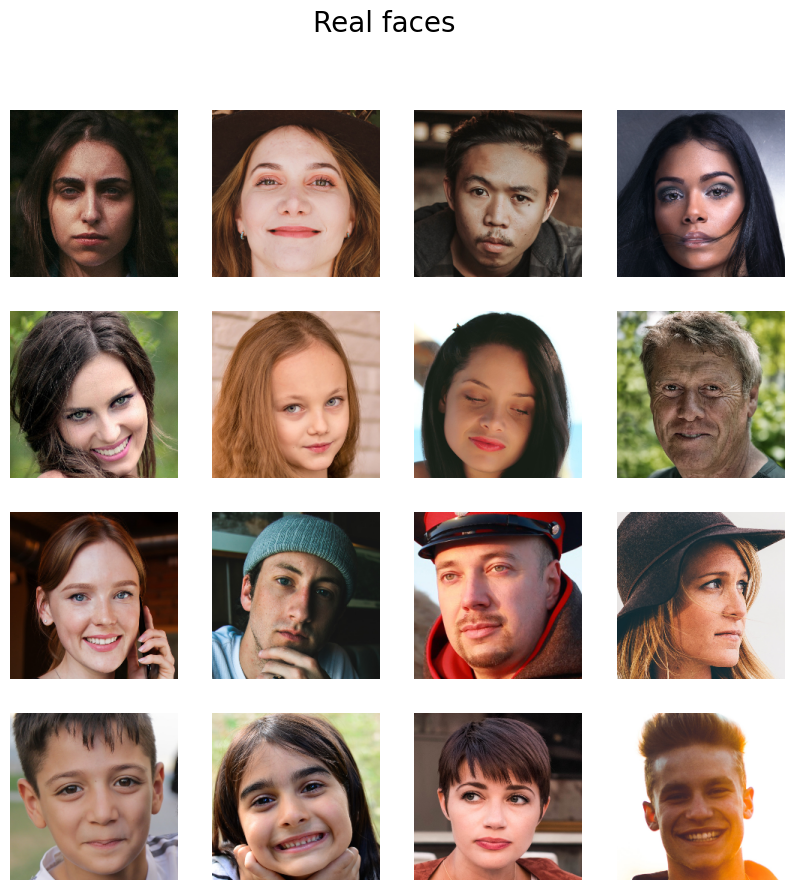

In [27]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')

plt.show()

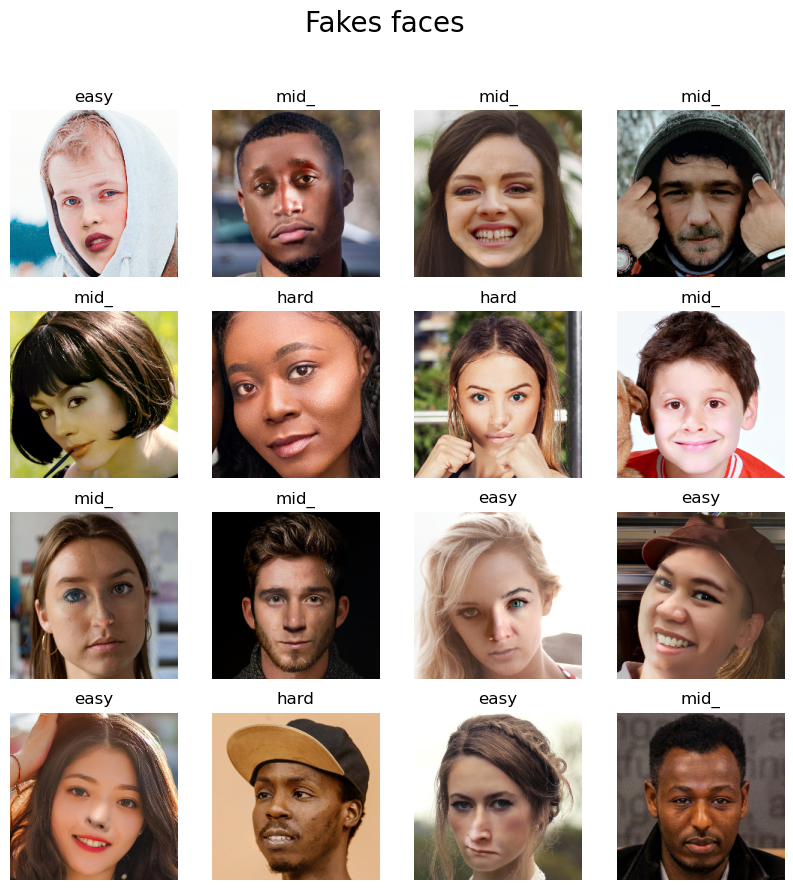

In [28]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()
    

## Data processing

In [29]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.Resize((96, 96)),        # Resize images to 96x96
    transforms.ToTensor(),              # Convert images to PyTorch Tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize images
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

dataset_size = len(full_dataset)
split = int(np.floor(0.2 * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_sampler)
validation_loader = DataLoader(full_dataset, batch_size=32, sampler=validation_sampler)

print(f"Found {len(train_indices)} images belonging to {len(full_dataset.classes)} classes for training.")
print(f"Found {len(val_indices)} images belonging to {len(full_dataset.classes)} classes for validation.")


Found 1633 images belonging to 2 classes for training.
Found 408 images belonging to 2 classes for validation.


## Model training

In [45]:
def evaluate_model(validation_loader, model, criterion):
    model.eval()  # Make sure the model is in eval mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct / total
    
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    
    return val_loss, val_accuracy

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 2)  # Assuming 2 classes: real and fake
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 2)  # Assuming 2 classes: real and fake
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.pool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x




#### SimpleCNN Model

In [47]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []


# Training Loop
# def train_model(train_loader, model, criterion, optimizer, epochs=20):
#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)  # Move data to GPU
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
#         evaluate_model(validation_loader, model)

def train_model(train_loader, validation_loader, model, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        val_loss, val_accuracy = evaluate_model(validation_loader, model, criterion)

        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")



In [48]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []


model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader, validation_loader, model, criterion, optimizer)

Validation Loss: 0.6880957300846393, Validation Accuracy: 0.5588235294117647
Epoch 1/20 - Loss: 0.7045, Accuracy: 0.52%, Val Loss: 0.6881, Val Accuracy: 0.56%
Validation Loss: 0.6827312937149634, Validation Accuracy: 0.5392156862745098
Epoch 2/20 - Loss: 0.6856, Accuracy: 0.54%, Val Loss: 0.6827, Val Accuracy: 0.54%
Validation Loss: 0.6667787937017587, Validation Accuracy: 0.5980392156862745
Epoch 3/20 - Loss: 0.6743, Accuracy: 0.59%, Val Loss: 0.6668, Val Accuracy: 0.60%
Validation Loss: 0.6828425801717318, Validation Accuracy: 0.5465686274509803
Epoch 4/20 - Loss: 0.6724, Accuracy: 0.57%, Val Loss: 0.6828, Val Accuracy: 0.55%
Validation Loss: 0.672248377249791, Validation Accuracy: 0.5490196078431373
Epoch 5/20 - Loss: 0.6702, Accuracy: 0.59%, Val Loss: 0.6722, Val Accuracy: 0.55%
Validation Loss: 0.6632311756794269, Validation Accuracy: 0.6200980392156863
Epoch 6/20 - Loss: 0.6765, Accuracy: 0.57%, Val Loss: 0.6632, Val Accuracy: 0.62%
Validation Loss: 0.6643553651296176, Validation

In [49]:
# model = SimpleCNN().to(device)

summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Linear-10                  [-1, 512]       9,437,696
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 9,531,970
Trainable params: 9,531,970
Non-trainable params: 0
---------------------------

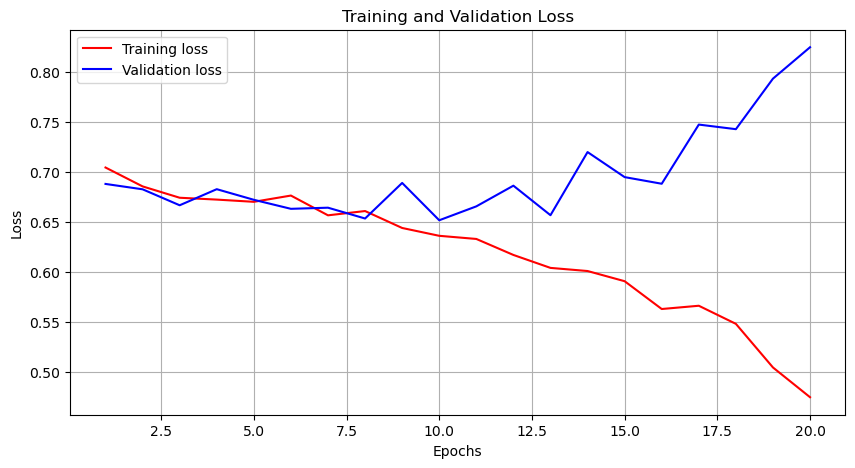

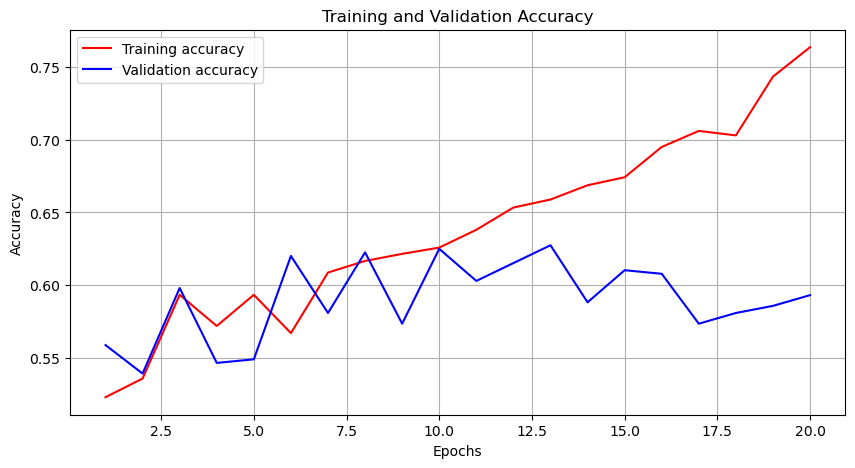

In [50]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]


epochs = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### ImprovedCNN Training

In [51]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader, validation_loader, model, criterion, optimizer)

Validation Loss: 0.6913101214628953, Validation Accuracy: 0.5637254901960784
Epoch 1/20 - Loss: 1.1502, Accuracy: 0.54%, Val Loss: 0.6913, Val Accuracy: 0.56%
Validation Loss: 0.76166170835495, Validation Accuracy: 0.5441176470588235
Epoch 2/20 - Loss: 0.6843, Accuracy: 0.58%, Val Loss: 0.7617, Val Accuracy: 0.54%
Validation Loss: 0.699920668051793, Validation Accuracy: 0.5441176470588235
Epoch 3/20 - Loss: 0.6702, Accuracy: 0.61%, Val Loss: 0.6999, Val Accuracy: 0.54%
Validation Loss: 0.7007187375655541, Validation Accuracy: 0.5612745098039216
Epoch 4/20 - Loss: 0.6513, Accuracy: 0.61%, Val Loss: 0.7007, Val Accuracy: 0.56%
Validation Loss: 0.6866501798996558, Validation Accuracy: 0.5882352941176471
Epoch 5/20 - Loss: 0.6465, Accuracy: 0.62%, Val Loss: 0.6867, Val Accuracy: 0.59%
Validation Loss: 0.6922498803872329, Validation Accuracy: 0.571078431372549
Epoch 6/20 - Loss: 0.6177, Accuracy: 0.66%, Val Loss: 0.6922, Val Accuracy: 0.57%
Validation Loss: 0.6525230682813205, Validation Ac

In [52]:
summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
       BatchNorm2d-3           [-1, 32, 96, 96]              64
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
              ReLU-6           [-1, 64, 48, 48]               0
       BatchNorm2d-7           [-1, 64, 48, 48]             128
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
             ReLU-10          [-1, 128, 24, 24]               0
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
             ReLU-14          [-1, 256,

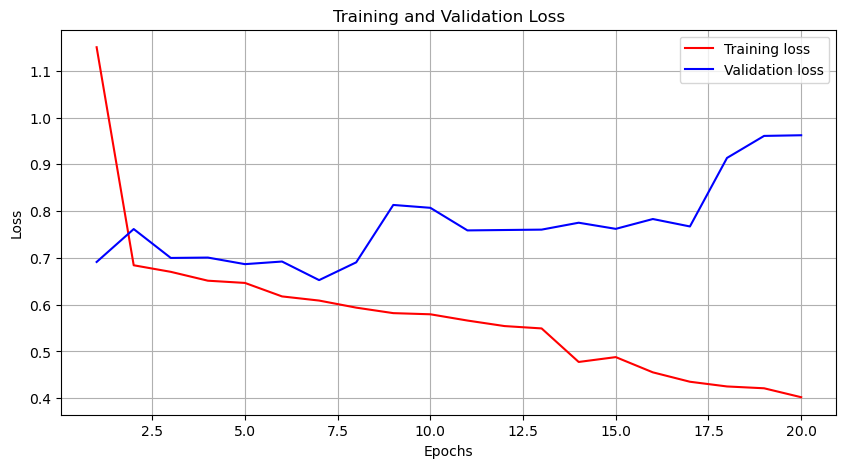

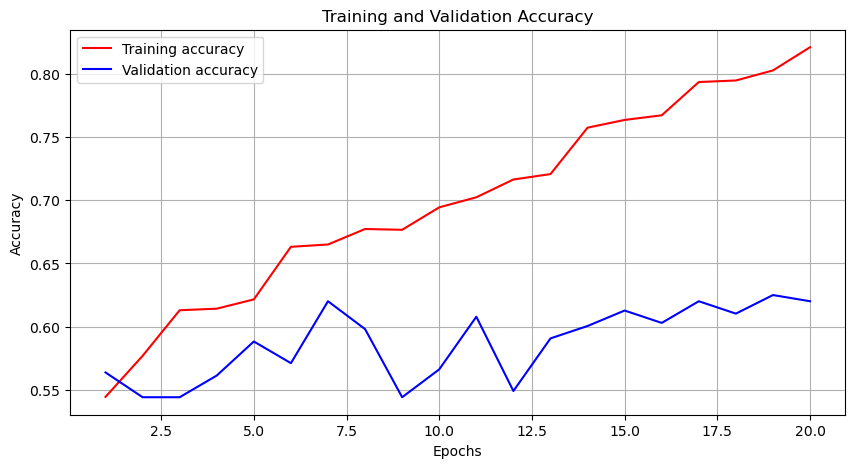

In [53]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]


epochs = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()